<a href="https://colab.research.google.com/github/hsilva-unam/THC_Semestre_06_01_ProyectoFinal/blob/main/THC_Proyecto_Final_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== Dimensiones de la base =====
Filas, columnas: (50418, 9)

===== Información de columnas (df.info()) =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50418 entries, 0 to 50417
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   CODE     50418 non-null  object        
 1   COUNTRY  50418 non-null  object        
 2   DATE     50418 non-null  datetime64[ns]
 3   HDI      44216 non-null  float64       
 4   TC       50418 non-null  float64       
 5   TD       50418 non-null  float64       
 6   STI      50418 non-null  float64       
 7   POP      50418 non-null  float64       
 8   GDPCAP   50418 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 3.5+ MB
None

===== Resumen estadístico (df.describe(include='all')) =====
         CODE      COUNTRY                           DATE           HDI  \
count   50418        50418                          50418  44216.000000 

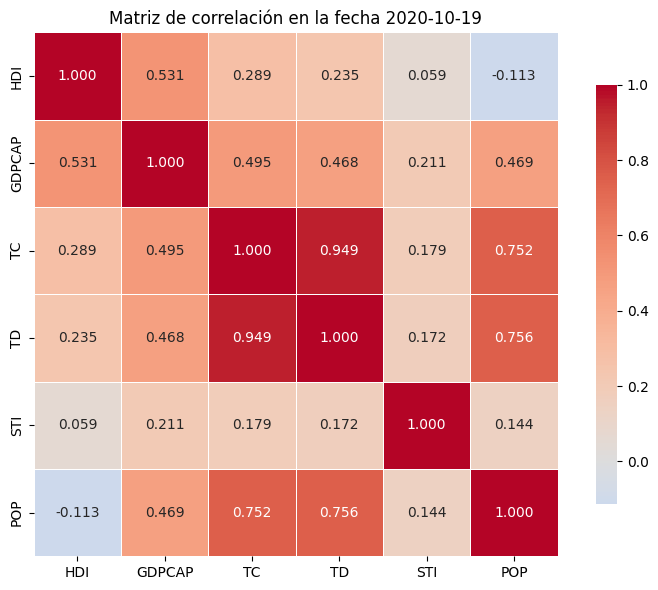

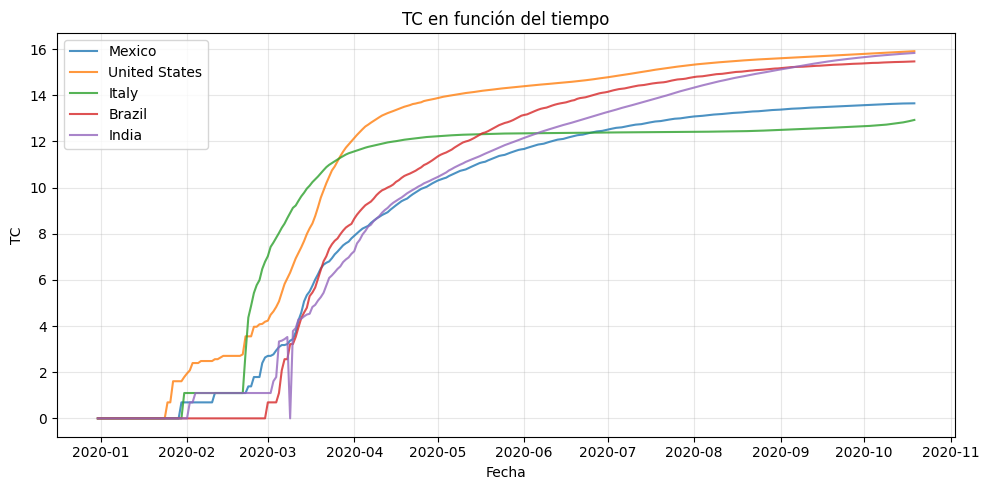

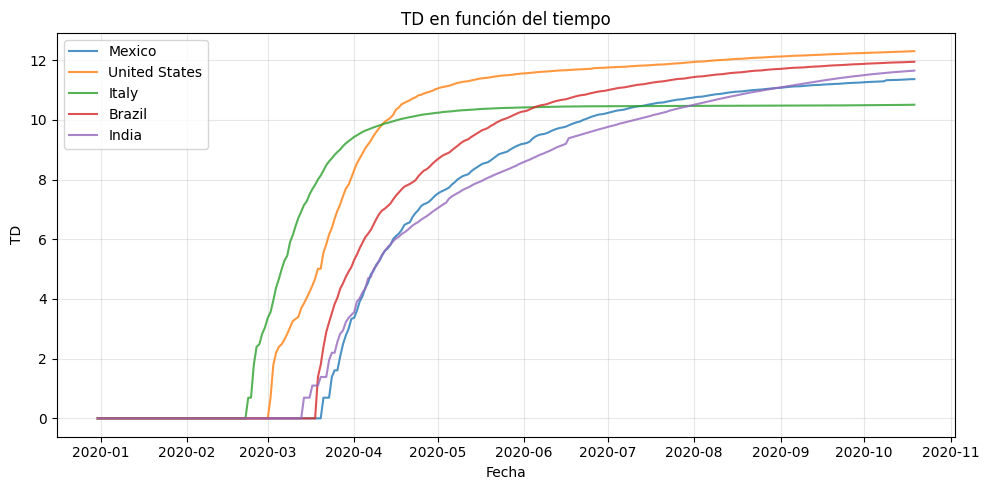

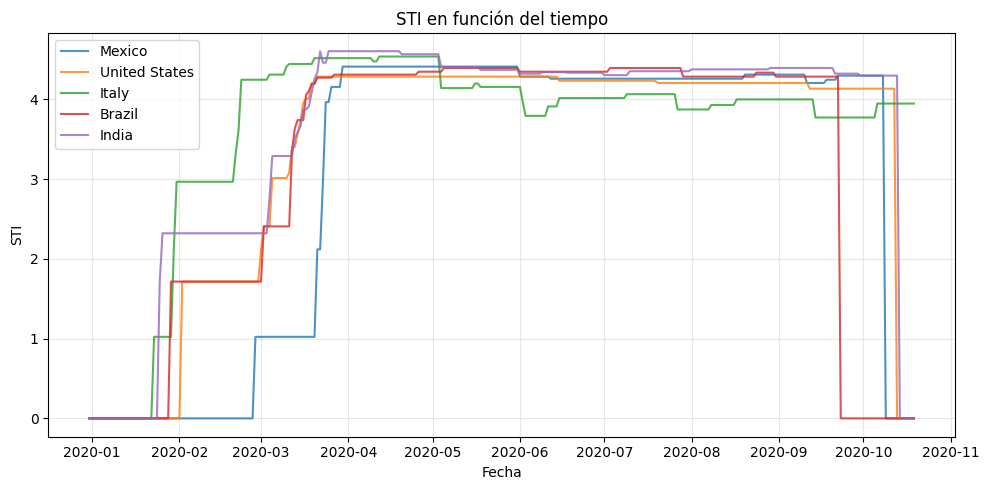

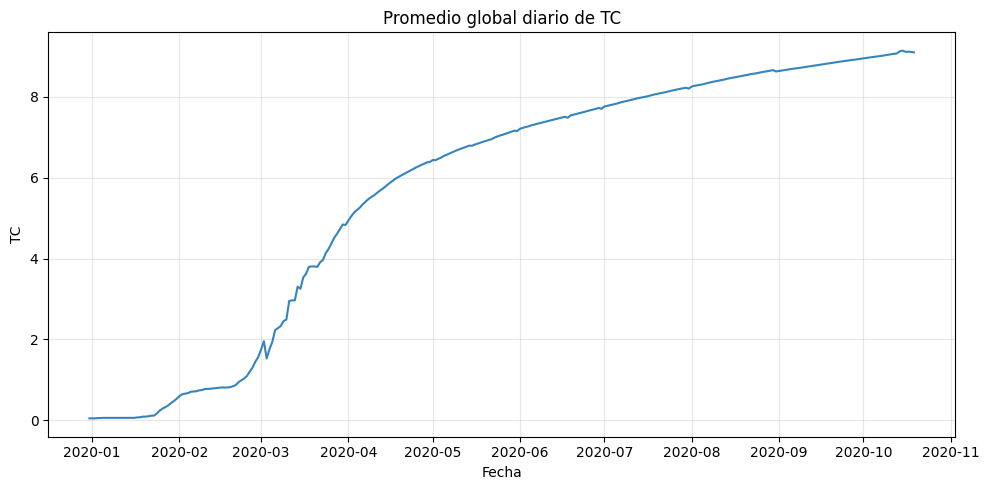

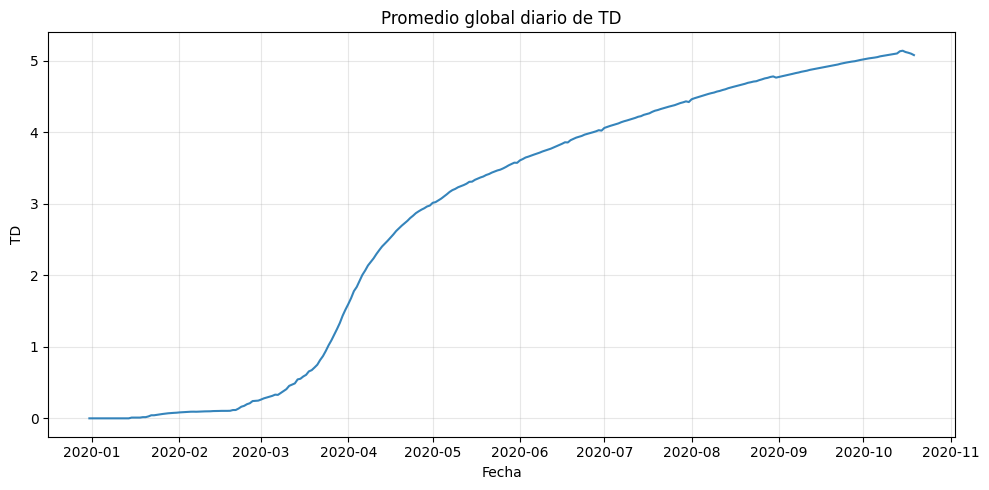

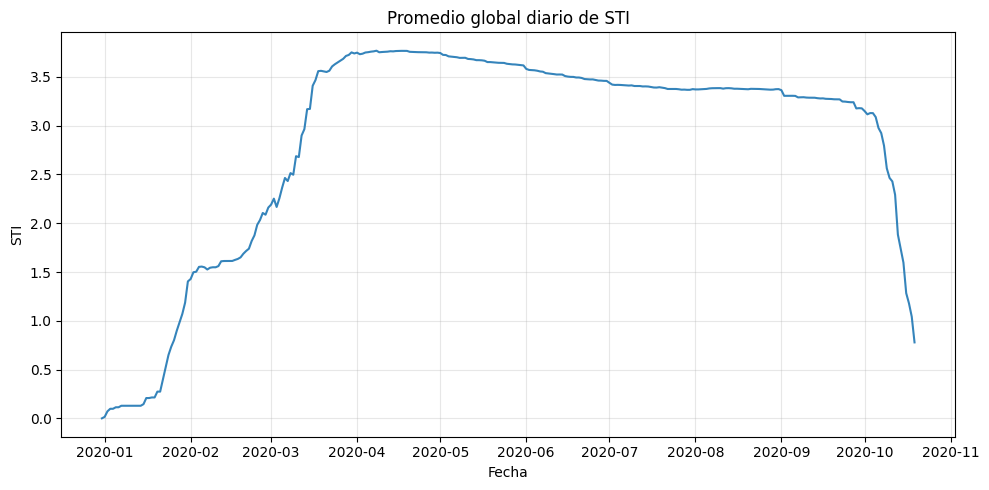

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # ### CAMBIO: import para la matriz de correlación coloreada


RUTA_CSV = "/content/ECOVSCOVID.csv"


def cargar_datos(ruta: str) -> pd.DataFrame:
    """
    Carga la base de datos de COVID y convierte la columna DATE a tipo datetime.
    """
    df = pd.read_csv(ruta)
    df["DATE"] = pd.to_datetime(df["DATE"])
    return df


def resumen_datos(df: pd.DataFrame) -> None:
    """
    Imprime información general y resumen estadístico de la base.
    """
    print("===== Dimensiones de la base =====")
    print("Filas, columnas:", df.shape)
    print("\n===== Información de columnas (df.info()) =====")
    print(df.info())
    print("\n===== Resumen estadístico (df.describe(include='all')) =====")
    print(df.describe(include="all"))


def datos_faltantes(df: pd.DataFrame) -> None:
    """
    Muestra el número de datos faltantes por columna.
    """
    print("\n===== Datos faltantes por columna =====")
    na_counts = df.isna().sum().sort_values(ascending=False)
    print(na_counts)


def imputar_hdi(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputa los valores faltantes de HDI usando el promedio por país.

    Justificación: el HDI es prácticamente constante en el tiempo
    para cada país; por tanto, usar el promedio por país no distorsiona
    el análisis.
    """
    df = df.copy()
    df["HDI"] = df.groupby("COUNTRY")["HDI"].transform(
        lambda s: s.fillna(s.mean())
    )
    return df


def correlaciones_ultimo_dia(df: pd.DataFrame, fecha: str = None) -> None:
    """
    Calcula la matriz de correlación entre HDI, GDPCAP, TC, TD, STI y POP
    en una fecha específica (por defecto, la última fecha disponible).

    Además de imprimir la matriz numérica, muestra un mapa de calor
    (heatmap) coloreado de dicha matriz.
    """
    if fecha is None:
        fecha = df["DATE"].max()
    else:
        fecha = pd.to_datetime(fecha)

    subset = df[df["DATE"] == fecha]
    columnas = ["HDI", "GDPCAP", "TC", "TD", "STI", "POP"]
    corr = subset[columnas].corr()
    print(f"\n===== Correlaciones en la fecha {fecha.date()} =====")
    print(corr)

    # ### CAMBIO: gráfica de la matriz de correlación como heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr,
        annot=True,       # mostrar valores numéricos
        fmt=".3f",        # 3 decimales
        cmap="coolwarm",  # azul (negativo) - rojo (positivo)
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title(f"Matriz de correlación en la fecha {fecha.date()}")
    plt.tight_layout()
    plt.show()
    # ### FIN CAMBIO


def graficar_parametros_por_pais(
    df: pd.DataFrame,
    paises: list,
    parametros: list
) -> None:
    """
    Genera gráficas de parámetros (TC, TD, STI, etc.) en función del tiempo
    para una lista de países.

    Cada parámetro se grafica en una figura distinta.
    """
    for param in parametros:
        plt.figure(figsize=(10, 5))
        for pais in paises:
            subset = df[df["COUNTRY"] == pais]
            if subset.empty:
                continue
            plt.plot(subset["DATE"], subset[param], label=pais, alpha=0.8)
        plt.title(f"{param} en función del tiempo")
        plt.xlabel("Fecha")
        plt.ylabel(param)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def graficar_promedios_globales(df: pd.DataFrame, parametros: list) -> None:
    """
    Grafica la evolución temporal de los promedios globales (por fecha)
    de los parámetros indicados.
    """
    df_group = df.groupby("DATE")[parametros].mean().reset_index()

    for param in parametros:
        plt.figure(figsize=(10, 5))
        plt.plot(df_group["DATE"], df_group[param], alpha=0.9)
        plt.title(f"Promedio global diario de {param}")
        plt.xlabel("Fecha")
        plt.ylabel(param)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def main():
    # 1. Cargar datos
    df = cargar_datos(RUTA_CSV)

    # 2. Análisis general
    resumen_datos(df)
    datos_faltantes(df)

    # 3. Manejo de datos faltantes en HDI
    df = imputar_hdi(df)
    print("\n===== Datos faltantes después de imputar HDI =====")
    print(df.isna().sum())

    # 4. Correlaciones en el último día disponible (numérico + heatmap)
    correlaciones_ultimo_dia(df)

    # 5. Gráficas por países
    # Puedes editar esta lista según los países que quieras analizar
    paises_interes = ["Mexico", "United States", "Italy", "Brazil", "India"]
    parametros_interes = ["TC", "TD", "STI"]

    graficar_parametros_por_pais(df, paises=paises_interes,
                                 parametros=parametros_interes)

    # 6. Gráficas de promedios globales por fecha
    graficar_promedios_globales(df, parametros_interes)


if __name__ == "__main__":
    main()